In [31]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import math
from openpyxl import Workbook

def psy_analytic(x, lamb = -1, case = 1):
    '''
        psy_analytic = np.exp(lamb*x)
    '''
    if case == 1:
        return tf.exp(lamb*x)
    elif case == 2:
        return tf.sin(x)
    elif case == 3:
        return -1 / (1 + x)

def f(x, psy, case = 1):
    if case == 1:
        '''
            d(psy)/dx = f(x, psy)
            y' = B(x) - A(x) * y
        '''
        def A(x, case = 1):
            if case == 1:
                return 1

        def B(x, case = 1):
            if case == 1:
                return 0

        return B(x) - A(x)*psy
    
    elif case == 2:
        '''
            Prothero Robinson
            y' 
        '''
        return -(psy - tf.sin(x)) + tf.cos(x)

    elif case == 3:
        return psy**2

def y(x, w, case = 1): 
    '''
        y(x) = bias + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + ... + wn*(x**n)
    '''
    if case == 1:
        bias = 1.
    elif case == 2:
        bias = 0.
    elif case == 3:
        bias = -1.

    y = bias
    w_v = w.variables[0]
    n = w_v.shape[0]
    for i in range(1, n+1):
        y += w_v[i-1]*x**i
    
    return y

def y_loss(x, w, case = 1):
    x = x.reshape(-1, 1)    # (x크기, 1)
    x = tf.constant(x, dtype = tf.float32)  # tensor 상수로 변형
    
    with tf.GradientTape() as tape:
        tape.watch(x)

        _y = y(x, w, case = case)
        d_y = tape.gradient(_y, x)
    
    _loss = d_y - f(x, _y, case)
    square_loss = tf.square(_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

def y_EC_loss(x, w, NN, case = 1):
    x = x.reshape(-1, 1)    # (x크기, 1)
    x = tf.constant(x, dtype = tf.float32)  # tensor 상수로 변형

    with tf.GradientTape() as tape:
        tape.watch(x)

        y_EC = tf.add(y(x, w, case), NN(x)*x)
        d_y_EC = tape.gradient(y_EC, x)

    _loss = d_y_EC - f(x, y_EC, case)
    square_loss = tf.square(_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

def PINN(x, NN, case = 1):
    x = x.reshape(-1, 1)
    x = tf.constant(x, dtype = tf.float32)
    x_0 = tf.zeros((1, 1))
    if case == 1:
        one = tf.ones((1, 1))
    elif case == 2:
        one = tf.zeros((1, 1))
    elif case == 3:
        one = -1*tf.ones((1, 1))

    with tf.GradientTape() as tape:
        tape.watch(x)

        PINN_NN = NN(x)
        d_PINN_NN = tape.gradient(PINN_NN, x)

    _loss = d_PINN_NN - f(x, PINN_NN, case)
    IC_loss = NN(x_0) - one
    square_loss = tf.square(_loss) + tf.square(IC_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss


def train(train_x, n, case):
    w = tf.Module()
    w.v = tf.Variable(tf.random.normal(shape=(n, ), dtype=tf.float32))

    NN = tf.keras.models.Sequential([
        tf.keras.layers.Input((1,)),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 1)
    ])

    learning_rate = 1e-3
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

    print('start y')
    for itr in range(3000):
        with tf.GradientTape() as tape:
            train_loss = y_loss(train_x, w, case)

            grad_w = tape.gradient(train_loss, w.trainable_variables)
            optimizer.apply_gradients(zip(grad_w, w.trainable_variables))

        if itr % 1000 == 0:
            print('iter : {}, loss : {}'.format(itr, train_loss.numpy()))

    print('start y + EC')
    for itr in range(3000):
        with tf.GradientTape() as tape:
            train_loss = y_EC_loss(train_x, w, NN, case)

            grad_NN = tape.gradient(train_loss, NN.trainable_variables)
            optimizer.apply_gradients(zip(grad_NN, NN.trainable_variables))

        if itr % 1000 == 0:
            print('iter : {}, loss : {}'.format(itr, train_loss.numpy()))
    
    return w, NN

def result_pred(train_x, case, w, NN):
    test_x = np.linspace(0, 1, 100).reshape(-1, 1)    # (x크기, 1)
    test_x = tf.constant(test_x, dtype = tf.float32)  # tensor 상수로 변형

    pred_y = y(test_x, w, case)
    NN_pred_y = tf.add(y(test_x, w, case), NN.predict(test_x)*test_x)

    test_x = np.linspace(0, 1, 100)
    train_y = psy_analytic(train_x, case = case)
    true_y = psy_analytic(test_x, case = case)

    return pred_y, NN_pred_y, train_y, true_y

def graph_show(train_x, train_y, true_y, pred_y, NN_pred_y):
    test_x = np.linspace(0, 1, 100).reshape(-1, 1)    # (x크기, 1)
    test_x = tf.constant(test_x, dtype = tf.float32)  # tensor 상수로 변형
    fig = plt.figure(figsize=(18,5))
    ax = fig.add_subplot(121)
    ax.plot(train_x, train_y, 'ob', label = 'Train')
    ax.plot(test_x, true_y, '-k', label = 'True')
    ax.plot(test_x, pred_y, '--r', label = 'Prediction')
    ax.plot(test_x, NN_pred_y, '--g', label = 'NN_Prediction')
    ax.tick_params(labelsize=10)
    ax.legend(fontsize=20)
    ax.grid()
    # Error
    ax2 = fig.add_subplot(122)
    plt.plot(test_x, tf.abs(np.array(pred_y).flatten() - true_y), '-r', label = 'Error')
    plt.plot(test_x, tf.abs(np.array(NN_pred_y).flatten() - true_y), '-g', label = 'NN_Error')
    ax2.tick_params(labelsize=10)
    ax2.legend(fontsize=20)
    ax2.grid()

def result_1(Epoch, case=1):
    '''
        result 1

        w 개수별
        polynomial Graph
        1. Exact
        2. 1st
        3. 2ed
        4. 3rd

        train_x = 0 ~ 1 사이 20개 균등 배열
        충분히 학습 될 때 까지, Epoch 10000
        Pn(x)로도 충분히 잘 근사 한다.
    '''
    wb = Workbook()
    ws1 = wb.active
    ws1.title = '1st loss, 2nd loss, 3rd loss'

    w_1 = tf.Module()
    w_1.v = tf.Variable(tf.random.normal(shape=(1, ), dtype=tf.float32))

    w_2 = tf.Module()
    w_2.v = tf.Variable(tf.random.normal(shape=(2, ), dtype=tf.float32))

    w_3 = tf.Module()
    w_3.v = tf.Variable(tf.random.normal(shape=(3, ), dtype=tf.float32))


    learning_rate = 1e-3
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    train_x = np.array([i/20 for i in range(20)]).reshape((-1, 1))

    print('start y')
    for itr in range(Epoch):
        with tf.GradientTape() as tape:
            train_loss_1 = y_loss(train_x, w_1, case)
            grad_w_1 = tape.gradient(train_loss_1, w_1.trainable_variables)
            optimizer.apply_gradients(zip(grad_w_1, w_1.trainable_variables))

        with tf.GradientTape() as tape:
            train_loss_2 = y_loss(train_x, w_2, case)
            grad_w_2 = tape.gradient(train_loss_2, w_2.trainable_variables)
            optimizer.apply_gradients(zip(grad_w_2, w_2.trainable_variables))

        with tf.GradientTape() as tape:
            train_loss_3 = y_loss(train_x, w_3, case)
            grad_w_3 = tape.gradient(train_loss_3, w_3.trainable_variables)
            optimizer.apply_gradients(zip(grad_w_3, w_3.trainable_variables))

        ws1.append(list(map(float, [train_loss_1, train_loss_2, train_loss_3])))

        if itr % 5000 == 0:
            print('iter : {}, loss_1 : {}'.format(itr, train_loss_1.numpy()))
            print('iter : {}, loss_2 : {}'.format(itr, train_loss_2.numpy()))
            print('iter : {}, loss_3 : {}'.format(itr, train_loss_3.numpy()))
    
    # show_graph
    test_x = np.linspace(0, 1, 100)
    train_y = psy_analytic(train_x, lamb = -1, case = case)
    true_y = psy_analytic(test_x, lamb = -1, case = case)
    test_x = np.linspace(0, 1, 100).reshape(-1, 1)    # (x크기, 1)
    test_x = tf.constant(test_x, dtype = tf.float32)  # tensor 상수로 변형
    pred_y_1 = y(test_x, w_1, case)
    pred_y_2 = y(test_x, w_2, case)
    pred_y_3 = y(test_x, w_3, case)

    fig = plt.figure(figsize=(18,5))
    ax = fig.add_subplot(121)
    ax.plot(test_x, true_y, '--k', label = 'Exact')
    ax.plot(test_x, pred_y_1, '-r', label = '1st')
    ax.plot(test_x, pred_y_2, '-g', label = '2ed')
    ax.plot(test_x, pred_y_3, '-b', label = '3rd')
    ax.set_xlabel('x', fontsize=15)
    ax.set_ylabel('y', fontsize=15)
    ax.set_title('y', fontsize=15)
    ax.tick_params(labelsize=10)
    ax.legend(fontsize=15)
    ax.grid()
    # Error
    ax2 = fig.add_subplot(122)
    ax2.plot(test_x, tf.abs(np.array(pred_y_1).flatten() - true_y), '-r', label = '1st Error')
    ax2.plot(test_x, tf.abs(np.array(pred_y_2).flatten() - true_y), '-g', label = '2ed Error')
    ax2.plot(test_x, tf.abs(np.array(pred_y_3).flatten() - true_y), '-b', label = '3rd Error')
    ax2.set_xlabel('x', fontsize=15)
    ax2.set_ylabel('Error', fontsize=15)
    ax2.set_title('Error', fontsize=15)
    ax2.tick_params(labelsize=10)
    ax2.legend( fontsize=15)
    ax2.grid()

    ws2 = wb.create_sheet(title = 'Pred 1st, Pred 2nd, Pred 3rd')
    for _1, _2, _3 in zip(pred_y_1, pred_y_2, pred_y_3):
        ws2.append(list(map(float, [_1, _2, _3])))
    if case == 1:
        wb.save('expansion20221227_Example1_exel_result1.xlsx')
    elif case == 3:
        wb.save('expansion20221227_Example2_exel_result1.xlsx')
    elif case == 2:
        wb.save('expansion20221227_Example3_exel_result1.xlsx')
    
def result_2(Epoch, case):
    '''
        result 2

        Error
        Poly + EC vs PINN

        setting
        train_x : 0 ~ 1 사이 20개 (균등 분배)
        layer 개수 : 4개
        weight : 32, 64, 64, 32
        optimizer function : tanh

        Poly weight 개수 : 3개
        Poly Epoch : 10,000

        Poly + EC, PINN Epoch : 1000, 10000
    '''
    wb = Workbook()
    ws1 = wb.active
    ws1.title = 'y_1+EC loss, y_2+EC loss, y_3+EC loss, PINN loss'

    w_1 = tf.Module()
    w_1.v = tf.Variable(tf.random.normal(shape=(1, ), dtype=tf.float32))

    w_2 = tf.Module()
    w_2.v = tf.Variable(tf.random.normal(shape=(2, ), dtype=tf.float32))

    w_3 = tf.Module()
    w_3.v = tf.Variable(tf.random.normal(shape=(3, ), dtype=tf.float32))

    NN_1 = tf.keras.models.Sequential([
        tf.keras.layers.Input((1,)),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 1)
    ])

    NN_2 = tf.keras.models.Sequential([
        tf.keras.layers.Input((1,)),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 1)
    ])

    NN_3 = tf.keras.models.Sequential([
        tf.keras.layers.Input((1,)),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 1)
    ])

    PINN_NN = tf.keras.models.Sequential([
        tf.keras.layers.Input((1,)),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 1)
    ])

    learning_rate = 1e-3
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    train_x = np.array([i/20 for i in range(20)]).reshape((-1, 1))

    print('start y')
    for itr in range(Epoch):
        with tf.GradientTape() as tape:
            train_loss_1 = y_loss(train_x, w_1, case)
            grad_w_1 = tape.gradient(train_loss_1, w_1.trainable_variables)
            optimizer.apply_gradients(zip(grad_w_1, w_1.trainable_variables))

        with tf.GradientTape() as tape:
            train_loss_2 = y_loss(train_x, w_2, case)
            grad_w_2 = tape.gradient(train_loss_2, w_2.trainable_variables)
            optimizer.apply_gradients(zip(grad_w_2, w_2.trainable_variables))

        with tf.GradientTape() as tape:
            train_loss_3 = y_loss(train_x, w_3, case)
            grad_w_3 = tape.gradient(train_loss_3, w_3.trainable_variables)
            optimizer.apply_gradients(zip(grad_w_3, w_3.trainable_variables))

        ws1.append(list(map(float, [train_loss_1, train_loss_2, train_loss_3])))

        if itr % 5000 == 0:
            print('iter : {}, loss_1 : {}'.format(itr, train_loss_1.numpy()))
            print('iter : {}, loss_2 : {}'.format(itr, train_loss_2.numpy()))
            print('iter : {}, loss_3 : {}'.format(itr, train_loss_3.numpy()))

    print('start y + EC and PINN')
    for itr in range(Epoch):
        with tf.GradientTape() as tape:
            train_loss_1_NN = y_EC_loss(train_x, w_1, NN_1, case)
            grad_1_NN = tape.gradient(train_loss_1_NN, NN_1.trainable_variables)
            optimizer.apply_gradients(zip(grad_1_NN, NN_1.trainable_variables))

        with tf.GradientTape() as tape:
            train_loss_2_NN = y_EC_loss(train_x, w_2, NN_2, case)
            grad_2_NN = tape.gradient(train_loss_2_NN, NN_2.trainable_variables)
            optimizer.apply_gradients(zip(grad_2_NN, NN_2.trainable_variables))

        with tf.GradientTape() as tape:
            train_loss_3_NN = y_EC_loss(train_x, w_3, NN_3, case)
            grad_3_NN = tape.gradient(train_loss_3_NN, NN_3.trainable_variables)
            optimizer.apply_gradients(zip(grad_3_NN, NN_3.trainable_variables))
        
        with tf.GradientTape() as tape:
            train_loss_PINN = PINN(train_x, PINN_NN, case)
            grad_PINN_NN = tape.gradient(train_loss_PINN, PINN_NN.trainable_variables)
            optimizer.apply_gradients(zip(grad_PINN_NN, PINN_NN.trainable_variables))

        ws1.append(list(map(float, [train_loss_1_NN, train_loss_2_NN, train_loss_3_NN, train_loss_PINN])))

        if itr % 5000 == 0:
            print('iter : {}, yEC_loss : {}'.format(itr, train_loss_1_NN.numpy()))
            print('iter : {}, yEC_loss : {}'.format(itr, train_loss_2_NN.numpy()))
            print('iter : {}, yEC_loss : {}'.format(itr, train_loss_3_NN.numpy()))
            print('iter : {}, PINN_loss : {}'.format(itr, train_loss_PINN.numpy()))

    # show_graph
    test_x = np.linspace(0, 1, 100)
    true_y = psy_analytic(test_x, lamb = -1, case=case)
    test_x = np.linspace(0, 1, 100).reshape(-1, 1)    # (x크기, 1)
    test_x = tf.constant(test_x, dtype = tf.float32)  # tensor 상수로 변형
    NN_1_pred_y = tf.add(y(test_x, w_1, case), NN_1.predict(test_x)*test_x)
    NN_2_pred_y = tf.add(y(test_x, w_2, case), NN_2.predict(test_x)*test_x)
    NN_3_pred_y = tf.add(y(test_x, w_3, case), NN_3.predict(test_x)*test_x)
    PINN_pred_y = PINN_NN.predict(test_x)

    fig = plt.figure(figsize=(18,5))

    # Error
    ax = fig.add_subplot(122)
    ax.plot(test_x, tf.abs(np.array(NN_1_pred_y).flatten() - true_y), '-r', label = 'y_1 + EC')
    ax.plot(test_x, tf.abs(np.array(NN_2_pred_y).flatten() - true_y), '-g', label = 'y_2 + EC')
    ax.plot(test_x, tf.abs(np.array(NN_3_pred_y).flatten() - true_y), '-b', label = 'y_3 + EC')
    ax.plot(test_x, tf.abs(np.array(PINN_pred_y).flatten() - true_y), '-k', label = 'PINN')
    ax.set_xlabel('x', fontsize=15)
    ax.set_ylabel('Error', fontsize=15)
    ax.set_title('Error', fontsize=15)
    ax.tick_params(labelsize=10)
    ax.legend( fontsize=15)
    ax.grid()

    ws2 = wb.create_sheet(title = '1+NN, 2+NN, 3+NN, PINN')
    for NN_1, NN_2, NN_3, _PINN in zip(NN_1_pred_y, NN_2_pred_y, NN_3_pred_y, PINN_pred_y):
        ws2.append(list(map(float, [NN_1, NN_2, NN_3, _PINN])))
    if case == 1:
        wb.save('expansion20221227_Example1_exel_result2.xlsx') 
    elif case == 3:
        wb.save('expansion20221227_Example2_exel_result2.xlsx')
    elif case == 2:
        wb.save('expansion20221227_Example3_exel_result2.xlsx')

def while_result_2(Epoch, case):
    '''
        result 2

        Error
        Poly + EC vs PINN

        setting
        train_x : 0 ~ 1 사이 20개 (균등 분배)
        layer 개수 : 4개
        weight : 32, 64, 64, 32
        optimizer function : tanh

        Poly weight 개수 : 3개
        Poly Epoch : 10,000

        Poly + EC, PINN Epoch : 1000, 10000
    '''
    cnt = 0
    while True:
        wb = Workbook()
        ws1 = wb.active
        ws1.title = 'y_1+EC loss, y_2+EC loss, y_3+EC loss, PINN loss'

        w_1 = tf.Module()
        w_1.v = tf.Variable(tf.random.normal(shape=(1, ), dtype=tf.float32))

        w_2 = tf.Module()
        w_2.v = tf.Variable(tf.random.normal(shape=(2, ), dtype=tf.float32))

        w_3 = tf.Module()
        w_3.v = tf.Variable(tf.random.normal(shape=(3, ), dtype=tf.float32))

        NN_1 = tf.keras.models.Sequential([
            tf.keras.layers.Input((1,)),
            tf.keras.layers.Dense(units = 32, activation = 'tanh'),
            tf.keras.layers.Dense(units = 64, activation = 'tanh'),
            tf.keras.layers.Dense(units = 64, activation = 'tanh'),
            tf.keras.layers.Dense(units = 32, activation = 'tanh'),
            tf.keras.layers.Dense(units = 1)
        ])

        NN_2 = tf.keras.models.Sequential([
            tf.keras.layers.Input((1,)),
            tf.keras.layers.Dense(units = 32, activation = 'tanh'),
            tf.keras.layers.Dense(units = 64, activation = 'tanh'),
            tf.keras.layers.Dense(units = 64, activation = 'tanh'),
            tf.keras.layers.Dense(units = 32, activation = 'tanh'),
            tf.keras.layers.Dense(units = 1)
        ])

        NN_3 = tf.keras.models.Sequential([
            tf.keras.layers.Input((1,)),
            tf.keras.layers.Dense(units = 32, activation = 'tanh'),
            tf.keras.layers.Dense(units = 64, activation = 'tanh'),
            tf.keras.layers.Dense(units = 64, activation = 'tanh'),
            tf.keras.layers.Dense(units = 32, activation = 'tanh'),
            tf.keras.layers.Dense(units = 1)
        ])

        PINN_NN = tf.keras.models.Sequential([
            tf.keras.layers.Input((1,)),
            tf.keras.layers.Dense(units = 32, activation = 'tanh'),
            tf.keras.layers.Dense(units = 64, activation = 'tanh'),
            tf.keras.layers.Dense(units = 64, activation = 'tanh'),
            tf.keras.layers.Dense(units = 32, activation = 'tanh'),
            tf.keras.layers.Dense(units = 1)
        ])

        learning_rate = 1e-3
        optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
        train_x = np.array([i/20 for i in range(20)]).reshape((-1, 1))

        print('start y')
        for itr in range(Epoch):
            with tf.GradientTape() as tape:
                train_loss_1 = y_loss(train_x, w_1, case)
                grad_w_1 = tape.gradient(train_loss_1, w_1.trainable_variables)
                optimizer.apply_gradients(zip(grad_w_1, w_1.trainable_variables))

            with tf.GradientTape() as tape:
                train_loss_2 = y_loss(train_x, w_2, case)
                grad_w_2 = tape.gradient(train_loss_2, w_2.trainable_variables)
                optimizer.apply_gradients(zip(grad_w_2, w_2.trainable_variables))

            with tf.GradientTape() as tape:
                train_loss_3 = y_loss(train_x, w_3, case)
                grad_w_3 = tape.gradient(train_loss_3, w_3.trainable_variables)
                optimizer.apply_gradients(zip(grad_w_3, w_3.trainable_variables))

            ws1.append(list(map(float, [train_loss_1, train_loss_2, train_loss_3])))

            if itr % 5000 == 0:
                print('iter : {}, loss_1 : {}'.format(itr, train_loss_1.numpy()))
                print('iter : {}, loss_2 : {}'.format(itr, train_loss_2.numpy()))
                print('iter : {}, loss_3 : {}'.format(itr, train_loss_3.numpy()))

        print('start y + EC and PINN')
        for itr in range(Epoch):
            with tf.GradientTape() as tape:
                train_loss_1_NN = y_EC_loss(train_x, w_1, NN_1, case)
                grad_1_NN = tape.gradient(train_loss_1_NN, NN_1.trainable_variables)
                optimizer.apply_gradients(zip(grad_1_NN, NN_1.trainable_variables))

            with tf.GradientTape() as tape:
                train_loss_2_NN = y_EC_loss(train_x, w_2, NN_2, case)
                grad_2_NN = tape.gradient(train_loss_2_NN, NN_2.trainable_variables)
                optimizer.apply_gradients(zip(grad_2_NN, NN_2.trainable_variables))

            with tf.GradientTape() as tape:
                train_loss_3_NN = y_EC_loss(train_x, w_3, NN_3, case)
                grad_3_NN = tape.gradient(train_loss_3_NN, NN_3.trainable_variables)
                optimizer.apply_gradients(zip(grad_3_NN, NN_3.trainable_variables))
            
            with tf.GradientTape() as tape:
                train_loss_PINN = PINN(train_x, PINN_NN, case)
                grad_PINN_NN = tape.gradient(train_loss_PINN, PINN_NN.trainable_variables)
                optimizer.apply_gradients(zip(grad_PINN_NN, PINN_NN.trainable_variables))

            ws1.append(list(map(float, [train_loss_1_NN, train_loss_2_NN, train_loss_3_NN, train_loss_PINN])))

            if itr % 5000 == 0:
                print('iter : {}, yEC_loss : {}'.format(itr, train_loss_1_NN.numpy()))
                print('iter : {}, yEC_loss : {}'.format(itr, train_loss_2_NN.numpy()))
                print('iter : {}, yEC_loss : {}'.format(itr, train_loss_3_NN.numpy()))
                print('iter : {}, PINN_loss : {}'.format(itr, train_loss_PINN.numpy()))

        # show_graph
        test_x = np.linspace(0, 1, 100)
        true_y = psy_analytic(test_x, lamb = -1, case=case)
        test_x = np.linspace(0, 1, 100).reshape(-1, 1)    # (x크기, 1)
        test_x = tf.constant(test_x, dtype = tf.float32)  # tensor 상수로 변형
        NN_1_pred_y = tf.add(y(test_x, w_1, case), NN_1.predict(test_x)*test_x)
        NN_2_pred_y = tf.add(y(test_x, w_2, case), NN_2.predict(test_x)*test_x)
        NN_3_pred_y = tf.add(y(test_x, w_3, case), NN_3.predict(test_x)*test_x)
        PINN_pred_y = PINN_NN.predict(test_x)
        NN_1_Error = tf.abs(np.array(NN_1_pred_y).flatten() - true_y)
        NN_2_Error = tf.abs(np.array(NN_2_pred_y).flatten() - true_y)
        NN_3_Error = tf.abs(np.array(NN_3_pred_y).flatten() - true_y)
        PINN_Error = tf.abs(np.array(PINN_pred_y).flatten() - true_y)
        cnt += 1
        print(cnt)
        if tf.reduce_sum(PINN_Error) > tf.reduce_sum(NN_1_Error) > tf.reduce_sum(NN_2_Error) > tf.reduce_sum(NN_3_Error):
            break

    fig = plt.figure(figsize=(18,5))

    # Error
    ax = fig.add_subplot(122)
    ax.plot(test_x, NN_1_Error, '-r', label = 'y_1 + EC')
    ax.plot(test_x, NN_2_Error, '-g', label = 'y_2 + EC')
    ax.plot(test_x, NN_3_Error, '-b', label = 'y_3 + EC')
    ax.plot(test_x, PINN_Error, '-k', label = 'PINN')
    ax.set_xlabel('x', fontsize=15)
    ax.set_ylabel('Error', fontsize=15)
    ax.set_title('Error', fontsize=15)
    ax.tick_params(labelsize=10)
    ax.legend( fontsize=15)
    ax.grid()

    ws2 = wb.create_sheet(title = '1+NN, 2+NN, 3+NN, PINN')
    for NN_1, NN_2, NN_3, _PINN in zip(NN_1_pred_y, NN_2_pred_y, NN_3_pred_y, PINN_pred_y):
        ws2.append(list(map(float, [NN_1, NN_2, NN_3, _PINN])))
    if case == 1:
        wb.save('expansion20221227_Example1_exel_result2.xlsx')
    elif case == 3:
        wb.save('expansion20221227_Example2_exel_result2.xlsx')
    elif case == 2:
        wb.save('expansion20221227_Example3_exel_result2.xlsx')
    

result 1
---
w 개수별
polynomial Graph
1. Exact
2. 1st
3. 2ed
4. 3rd

train_x = 0 ~ 1 사이 20개 균등 배열

충분히 학습 될 때 까지, Epoch 10000

Pn(x)로도 충분히 잘 근사 한다.

start y
iter : 0, loss_1 : 5.275788307189941
iter : 0, loss_2 : 30.46233558654785
iter : 0, loss_3 : 1.8476877212524414
iter : 5000, loss_1 : 0.036801330745220184
iter : 5000, loss_2 : 0.2806404232978821
iter : 5000, loss_3 : 0.03183279186487198


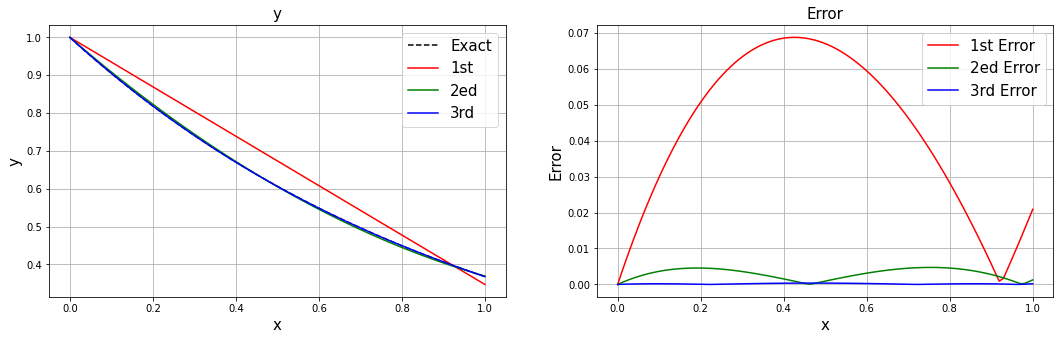

In [23]:
result_1(10000)

result 2
---
Error Graph

Poly + EC vs PINN

setting
---
train_x : 0 ~ 1 사이 20개 (균등 분배)

layer 개수 : 4개

weight : 32, 64, 64, 32

optimizer function : tanh

Poly weight 개수 : 3개

Poly Epoch : 10,000

Poly + EC, PINN Epoch : 1000, 10000

start y
iter : 0, y_loss : 1.555135726928711
iter : 1000, y_loss : 0.23617756366729736
iter : 2000, y_loss : 0.037251390516757965
iter : 3000, y_loss : 0.015614059753715992
iter : 4000, y_loss : 0.010285449214279652
iter : 5000, y_loss : 0.005297453608363867
iter : 6000, y_loss : 0.001791823306120932
iter : 7000, y_loss : 0.00030649156542494893
iter : 8000, y_loss : 2.0019026123918593e-05
iter : 9000, y_loss : 3.986881438322598e-06
start y + EC and PINN
iter : 0, yEC_loss : 0.06892586499452591
iter : 0, PINN_loss : 1.000885248184204
4/4 [==============================] - 0s 977us/step


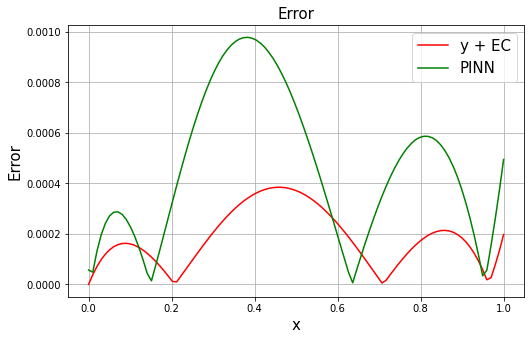

In [34]:
result_2(1000)

start y
iter : 0, loss_1 : 1.397039771080017
iter : 0, loss_2 : 12.629337310791016
iter : 0, loss_3 : 0.9116182327270508
iter : 5000, loss_1 : 0.036801327019929886
iter : 5000, loss_2 : 0.00688063632696867
iter : 5000, loss_3 : 0.00708813825622201
start y + EC and PINN
iter : 0, yEC_loss : 0.10223373025655746
iter : 0, yEC_loss : 1.180951714515686
iter : 0, yEC_loss : 0.11988667398691177
iter : 0, PINN_loss : 1.0061042308807373
iter : 5000, yEC_loss : 2.1341409137676237e-06
iter : 5000, yEC_loss : 5.105722721054917e-06
iter : 5000, yEC_loss : 3.2463351544720354e-06
iter : 5000, PINN_loss : 9.636691174819134e-06
4/4 [==============================] - 0s 977us/step


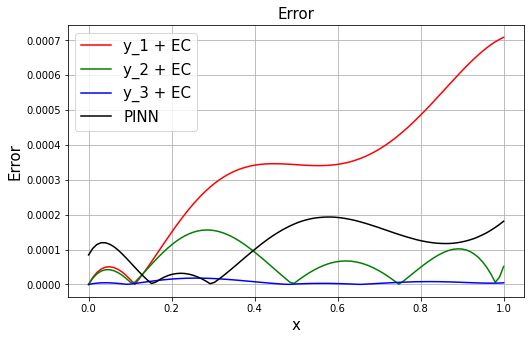

In [35]:
result_2(10000)

start y
iter : 0, loss_1 : 7.3094940185546875
iter : 0, loss_2 : 0.6402628421783447
iter : 0, loss_3 : 9.675199508666992
iter : 5000, loss_1 : 0.05541672557592392
iter : 5000, loss_2 : 0.003454479156062007
iter : 5000, loss_3 : 0.014510119333863258


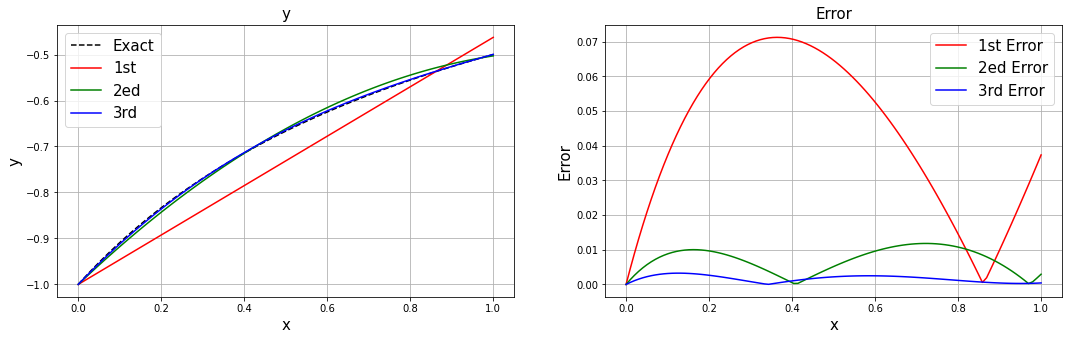

In [7]:
# Example2 result 1
result_1(Epoch=10000, case =3)

start y
iter : 0, loss_1 : 0.1310245245695114
iter : 0, loss_2 : 1.6202278137207031
iter : 0, loss_3 : 7.5087385177612305
iter : 5000, loss_1 : 0.05541672557592392
iter : 5000, loss_2 : 0.0034544928930699825
iter : 5000, loss_3 : 0.011149833910167217
start y + EC and PINN
iter : 0, yEC_loss : 0.13158395886421204
iter : 0, yEC_loss : 0.49443626403808594
iter : 0, yEC_loss : 0.0791187658905983
iter : 0, PINN_loss : 1.1201329231262207
iter : 5000, yEC_loss : 4.182592419965658e-06
iter : 5000, yEC_loss : 3.900875526596792e-05
iter : 5000, yEC_loss : 2.818268740156782e-06
iter : 5000, PINN_loss : 5.134708771947771e-06
4/4 [==============================] - 0s 2ms/step


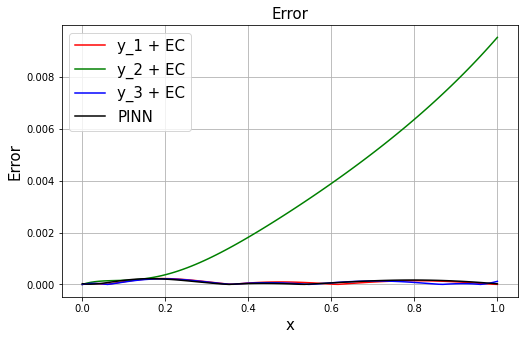

In [15]:
# Example2 result 2
result_2(Epoch=10000, case =3)

start y
iter : 0, loss_1 : 3.5354201793670654
iter : 0, loss_2 : 35.38884735107422
iter : 0, loss_3 : 0.8118241429328918
iter : 5000, loss_1 : 0.05541672557592392
iter : 5000, loss_2 : 0.2245744913816452
iter : 5000, loss_3 : 0.00021534645929932594
start y + EC and PINN
iter : 0, yEC_loss : 0.17045748233795166
iter : 0, yEC_loss : 0.2852778136730194
iter : 0, yEC_loss : 0.20202484726905823
iter : 0, PINN_loss : 1.0491529703140259
iter : 5000, yEC_loss : 0.001150041469372809
iter : 5000, yEC_loss : 1.3201854017097503e-05
iter : 5000, yEC_loss : 0.00017092283815145493
iter : 5000, PINN_loss : 1.9171050098520936e-06
4/4 [==============================] - 0s 3ms/step


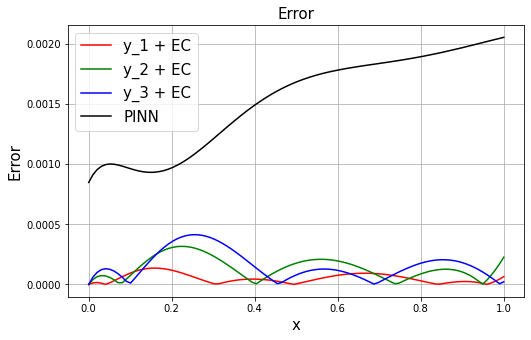

In [19]:
# Example2 result 2 27
result_2(Epoch=10000, case =3)

start y
iter : 0, loss_1 : 2.2223598957061768
iter : 0, loss_2 : 1.934644103050232
iter : 0, loss_3 : 0.26178374886512756
iter : 5000, loss_1 : 0.018918519839644432
iter : 5000, loss_2 : 0.0010717416880652308
iter : 5000, loss_3 : 2.4222716092481278e-05


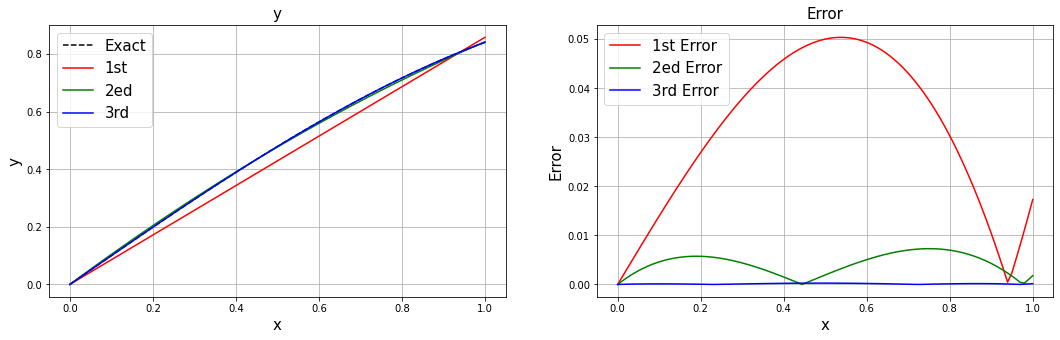

In [13]:
# Example3 result 1
result_1(Epoch=10000, case =2)

start y
iter : 0, loss_1 : 4.372565746307373
iter : 0, loss_2 : 7.992129325866699
iter : 0, loss_3 : 6.357118606567383
iter : 5000, loss_1 : 0.018918519839644432
iter : 5000, loss_2 : 0.003012887667864561
iter : 5000, loss_3 : 0.004079132340848446
start y + EC and PINN
iter : 0, yEC_loss : 0.24804821610450745
iter : 0, yEC_loss : 0.1738804131746292
iter : 0, yEC_loss : 0.3189047873020172
iter : 0, PINN_loss : 0.122444286942482
iter : 5000, yEC_loss : 1.868649633252062e-06
iter : 5000, yEC_loss : 2.457049276927137e-06
iter : 5000, yEC_loss : 4.7646167899983993e-07
iter : 5000, PINN_loss : 2.1481366275111213e-05
4/4 [==============================] - 0s 2ms/step


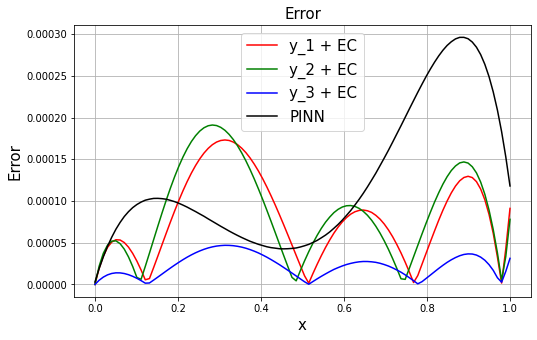

In [14]:
# Example3 result 2 1226
result_2(Epoch=10000, case =2)

start y
iter : 0, loss_1 : 0.04680774360895157
iter : 0, loss_2 : 13.833686828613281
iter : 0, loss_3 : 1.1610908508300781
iter : 5000, loss_1 : 0.01891852356493473
iter : 5000, loss_2 : 0.09951521456241608
iter : 5000, loss_3 : 0.0018003080040216446
start y + EC and PINN
iter : 0, yEC_loss : 0.02165083773434162
iter : 0, yEC_loss : 0.010821695439517498
iter : 0, yEC_loss : 0.003989475779235363
iter : 0, PINN_loss : 1.271052598953247
iter : 5000, yEC_loss : 3.0164094368956285e-06
iter : 5000, yEC_loss : 1.5424581079059863e-06
iter : 5000, yEC_loss : 1.6493249859195203e-06
iter : 5000, PINN_loss : 2.8497621315182187e-05
4/4 [==============================] - 0s 3ms/step


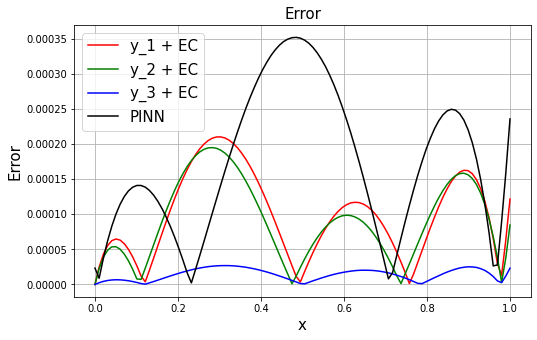

In [17]:
# Example3 result 2 1227
result_2(Epoch=10000, case =2)

c:\Users\kyungryeol\Anaconda3\envs\ODE\lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


start y
iter : 0, loss_1 : 1.557624101638794
iter : 0, loss_2 : 6.8248796463012695
iter : 0, loss_3 : 38.635528564453125
start y + EC and PINN
iter : 0, yEC_loss : 0.3849184811115265
iter : 0, yEC_loss : 2.8758883476257324
iter : 0, yEC_loss : 0.6821997761726379
iter : 0, PINN_loss : 1.0026413202285767
4/4 [==============================] - 0s 858us/step
1
start y
iter : 0, loss_1 : 2.3180973529815674
iter : 0, loss_2 : 0.9343168139457703
iter : 0, loss_3 : 2.6432769298553467
start y + EC and PINN
iter : 0, yEC_loss : 0.3983183801174164
iter : 0, yEC_loss : 0.010220879688858986
iter : 0, yEC_loss : 0.8408883810043335
iter : 0, PINN_loss : 1.231515884399414
4/4 [==============================] - 0s 666us/step
2
start y
iter : 0, loss_1 : 0.8950095176696777
iter : 0, loss_2 : 26.6298885345459
iter : 0, loss_3 : 4.22183084487915
start y + EC and PINN
iter : 0, yEC_loss : 0.25285565853118896
iter : 0, yEC_loss : 2.4764678478240967
iter : 0, yEC_loss : 0.7571053504943848
iter : 0, PINN_loss

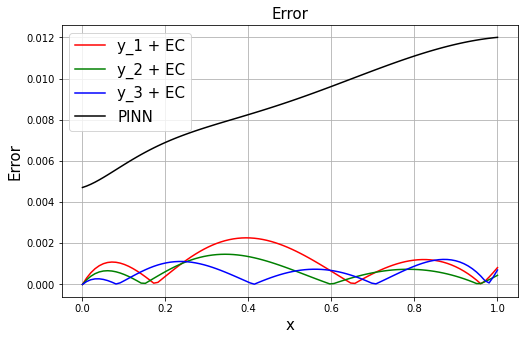

In [32]:
# Example2 result2
while_result_2(1000, case = 3)

start y
iter : 0, loss_1 : 4.772097587585449
iter : 0, loss_2 : 2.98174786567688
iter : 0, loss_3 : 1.3034499883651733
start y + EC and PINN
iter : 0, yEC_loss : 0.2761220633983612
iter : 0, yEC_loss : 1.3318251371383667
iter : 0, yEC_loss : 1.051964282989502
iter : 0, PINN_loss : 1.1786085367202759
4/4 [==============================] - 0s 652us/step
1
start y
iter : 0, loss_1 : 6.394562721252441
iter : 0, loss_2 : 6.046684741973877
iter : 0, loss_3 : 2.643979072570801
start y + EC and PINN
iter : 0, yEC_loss : 0.507172703742981
iter : 0, yEC_loss : 0.16722725331783295
iter : 0, yEC_loss : 0.105526402592659
iter : 0, PINN_loss : 1.794883370399475
4/4 [==============================] - 0s 977us/step
2
start y
iter : 0, loss_1 : 14.138859748840332
iter : 0, loss_2 : 1.5369560718536377
iter : 0, loss_3 : 39.32341384887695
start y + EC and PINN
iter : 0, yEC_loss : 1.8956546783447266
iter : 0, yEC_loss : 0.2826805114746094
iter : 0, yEC_loss : 3.2328591346740723
iter : 0, PINN_loss : 1.58

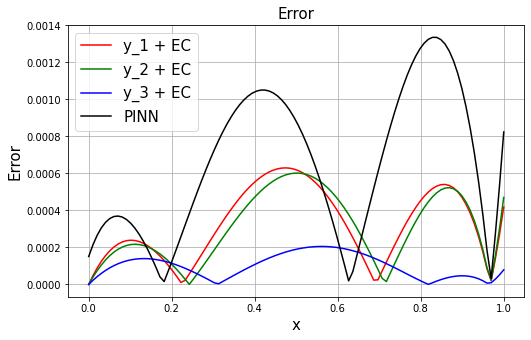

In [33]:
# Example3 result2
while_result_2(1000, case = 2)